In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Problem 1
Re-implement TSNE.

In [6]:
class MyTSNE:
    def __init__(self, n_components=2, perplexity=30, learning_rate=200, n_iter=1000):
        self.n_components = n_components
        self.perplexity = perplexity
        self.learning_rate = learning_rate
        self.n_iter = n_iter

    def _compute_distances(self, X):
        return np.sum((X[:, np.newaxis] - X) ** 2, axis=-1)

    def _compute_prob_gaussian(self, distances):
        return np.exp(-distances / (2 * self.perplexity ** 2 - np.finfo(np.float32).eps)) # type: ignore

    def _compute_prob_student_t(self, distances):
        return 1 / (1 + distances)

    def _symmetrize(self, P):
        return (P + P.T) / (2 * P.shape[0])

    def _compute_P(self, X):
        distances = self._compute_distances(X)
        P = self._compute_prob_gaussian(distances)
        P /= P.sum(axis=1, keepdims=True)
        return self._symmetrize(P)

    def _compute_Q(self, Z):
        distances = self._compute_distances(Z)
        Q = self._compute_prob_student_t(distances)
        Q /= Q.sum(axis=1, keepdims=True)
        return self._symmetrize(Q)

    def _compute_grad(self, P, Q, X, Z):
        diff = Z[:, np.newaxis, :] - Z
        grad = 4 * np.einsum('ij,ijk,jk->ij', P - Q, diff, 1 / (1 + np.sum(diff ** 2, axis=-1)))
        return grad

    def fit_transform(self, X):
        m, n = X.shape
        Z = np.random.normal(0, 1e-4, (m, self.n_components)).astype(np.float32)
        P = self._compute_P(X)

        for i in range(self.n_iter):
            Q = self._compute_Q(Z)
            grad = self._compute_grad(P, Q, X, Z)
            Z -= self.learning_rate * grad

            if i % 100 == 0:
                loss = np.sum((P - Q) ** 2)
                print(f'Iteration {i}, loss = {loss}')

        return Z


# Problem 2
Load MNIST dataset and visualize the image.

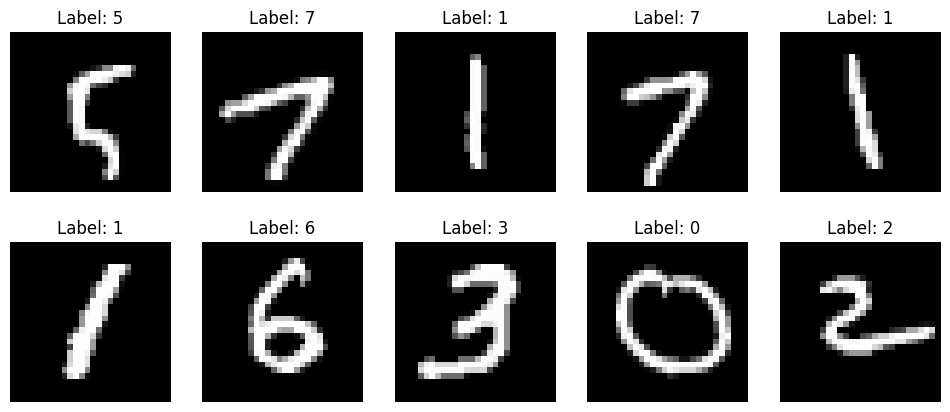

In [2]:
# Load MNIST dataset and visualize the image.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Show 10 classes of the dataset
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i in range(100, 110):
    ax = axes[i // 5 - 20, i % 5]
    ax.imshow(X_train[i], cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.show()

# Problem 3
Use YOUR IMPLEMENTATION ON PCA, as well as the design of T-SNE from above to reduce dimension into 2 and 3 dimensions, then visualize them (You can use plotly to plot 3D chart to make it interactive). Give your comments on the result.

In [3]:
# Reshape the data
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [7]:
# Reduce the dimensionality of the data using t-SNE
tsne = MyTSNE(n_components=2, perplexity=30, n_iter=300)
X_train_tsne = tsne.fit_transform(X_train)

# Visualize the data
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train, palette='tab10')
plt.title('MNIST dataset')
plt.show()

: 

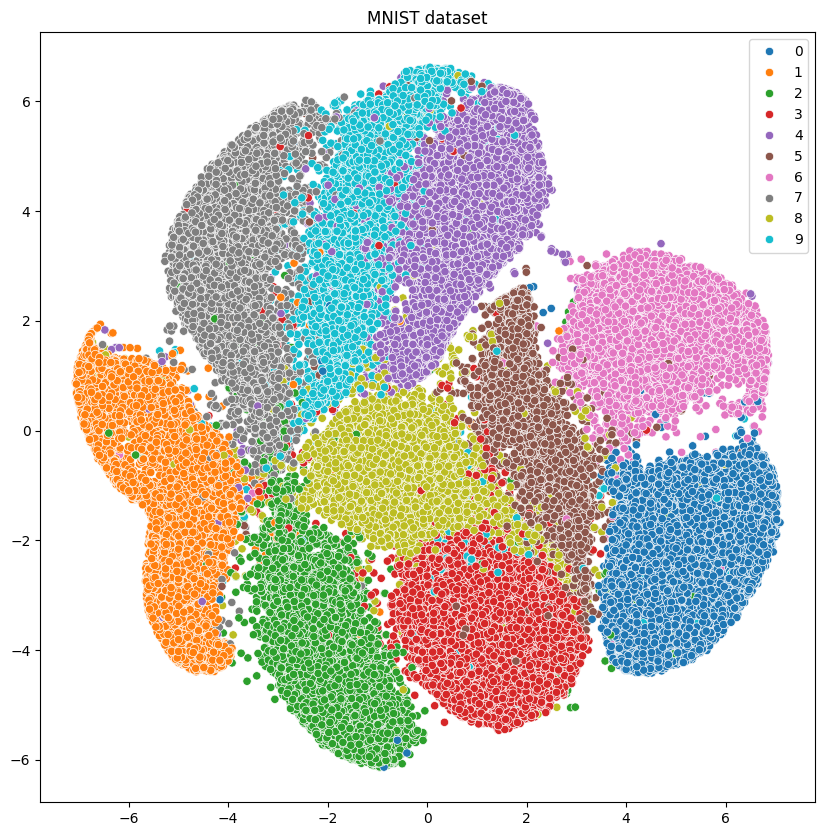

In [4]:
# Reduce the dimensionality of the data using TSNE from sklearn
tsne = TSNE(random_state=42, n_components=2, verbose=0, perplexity=30, n_iter=300, learning_rate=300)
X_train_tsne = tsne.fit_transform(X_train)

# Visualize the data
plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_train, palette='tab10')
plt.title('MNIST dataset')
plt.show()